<a href="https://colab.research.google.com/github/Nrnsaaaa/Big-Data-Analysis/blob/main/TugasBesar_BDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ============================================
# #BAGIAN_0_ENVIRONMENT_SETUP
# ============================================

!pip install pyspark --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sns.set(style="whitegrid")

spark = SparkSession.builder.appName("BigData_Ecommerce").getOrCreate()
print("Spark version:", spark.version)

Spark version: 4.0.1


In [12]:
# ============================================
# #BAGIAN_1_DATA_UNDERSTANDING
# (LOAD CSV SEBAGAI STRING DULU)
# ============================================

csv_path = "/content/TugasBESAR_synthetic_ecommerce_bigdata_20000.csv"

schema_all_string = StructType([
    StructField("user_id", StringType(), True),
    StructField("age", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("city", StringType(), True),
    StructField("product_category", StringType(), True),
    StructField("price", StringType(), True),
    StructField("quantity", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("purchase_time", StringType(), True),
    StructField("delivery_days", StringType(), True),
    StructField("rating", StringType(), True),
    StructField("total_spent", StringType(), True),
])

df_spark_raw = spark.read.csv(
    csv_path,
    header=True,
    schema=schema_all_string
)

print("Schema awal (semua string):")
df_spark_raw.printSchema()
print("Contoh data:")
df_spark_raw.show(5, truncate=False)

print("Jumlah baris:", df_spark_raw.count())
print("Jumlah kolom:", len(df_spark_raw.columns))


Schema awal (semua string):
root
 |-- user_id: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- city: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- price: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- purchase_time: string (nullable = true)
 |-- delivery_days: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- total_spent: string (nullable = true)

Contoh data:
+-------+---+------+---------+----------------+-------+--------+--------------+-------------------+-------------+------+-----------+
|user_id|age|gender|city     |product_category|price  |quantity|payment_method|purchase_time      |delivery_days|rating|total_spent|
+-------+---+------+---------+----------------+-------+--------+--------------+-------------------+-------------+------+-----------+
|U02340 |24 |M     |Semarang |Fashion         |30000  |3       |

In [31]:
# ============================================
# #BAGIAN_2_0_BERSIHKAN_EMPTY_STRING_DAN_CAST
# ============================================

# Ubah '' atau whitespace menjadi NULL di semua kolom
df_spark_clean = df_spark_raw.select(
    *[
        when(
            col(c).isNull() | (col(c) == "") | col(c).rlike("^\\s+$"),
            None
        ).otherwise(col(c)).alias(c)
        for c in df_spark_raw.columns
    ]
)

# Cast ke tipe final yang benar
df_spark = df_spark_clean.select(
    col("user_id"),
    col("age").cast("int").alias("age"),
    col("gender"),
    col("city"),
    col("product_category"),
    col("price").cast("double").alias("price"),
    col("quantity").cast("int").alias("quantity"),
    col("payment_method"),
    to_timestamp(col("purchase_time"), "yyyy-MM-dd HH:mm:ss").alias("purchase_time"),
    col("delivery_days").cast("int").alias("delivery_days"),
    col("rating").cast("int").alias("rating"),
    col("total_spent").cast("double").alias("total_spent")
)

print("Schema setelah cast:")
df_spark.printSchema()
df_spark.show(5, truncate=False)


Schema setelah cast:
root
 |-- user_id: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- city: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- purchase_time: timestamp (nullable = true)
 |-- delivery_days: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- total_spent: double (nullable = true)

+-------+---+------+---------+----------------+---------+--------+--------------+-------------------+-------------+------+-----------+
|user_id|age|gender|city     |product_category|price    |quantity|payment_method|purchase_time      |delivery_days|rating|total_spent|
+-------+---+------+---------+----------------+---------+--------+--------------+-------------------+-------------+------+-----------+
|U02340 |24 |M     |Semarang |Fashion         |30000.0  |3       |PayLa

In [14]:
# ============================================
# #BAGIAN_2_1_CEK_MISSING_DUPLIKASI_OUTLIER
# ============================================

from pyspark.sql.functions import count

# Missing value per kolom
missing_df = df_spark.select(
    *[count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns]
)
missing_df.show()

# Duplikasi
dup_count = df_spark.count() - df_spark.dropDuplicates().count()
print("Jumlah baris duplikat:", dup_count)

# Statistik numerik
num_cols = ["price", "quantity", "delivery_days", "age", "rating", "total_spent"]
df_spark.select(num_cols).describe().show()

# Quantile untuk outlier
quantiles = df_spark.approxQuantile(
    ["price", "quantity", "delivery_days"], [0.25, 0.75], 0.05
)
print("Quantiles (0.25 & 0.75) price, quantity, delivery_days:", quantiles)


+-------+---+------+----+----------------+-----+--------+--------------+-------------+-------------+------+-----------+
|user_id|age|gender|city|product_category|price|quantity|payment_method|purchase_time|delivery_days|rating|total_spent|
+-------+---+------+----+----------------+-----+--------+--------------+-------------+-------------+------+-----------+
|      0|  0|     0|   0|               0|    0|       0|             0|            0|            0|     0|          0|
+-------+---+------+----+----------------+-----+--------+--------------+-------------+-------------+------+-----------+

Jumlah baris duplikat: 0
+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|             price|          quantity|    delivery_days|              age|            rating|       total_spent|
+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  count

In [15]:
# ============================================
# #BAGIAN_2_2_PREPROCESSING_UTAMA
# ============================================

# 1) Drop duplikasi
df_spark = df_spark.dropDuplicates()

# 2) Drop missing di kolom kritikal
critical_cols = ["user_id", "price", "quantity", "total_spent"]
df_spark = df_spark.dropna(subset=critical_cols)

# 3) Isi rata-rata untuk beberapa numerik (jika masih ada NULL)
for c in ["age", "delivery_days", "rating"]:
    if c in df_spark.columns:
        mean_val = df_spark.agg(avg(col(c))).first()[0]
        if mean_val is not None:
            df_spark = df_spark.fillna({c: float(mean_val)})

# 4) Feature engineering: age_group
df_spark = df_spark.withColumn(
    "age_group",
    when(col("age") < 25, "Young")
    .when((col("age") >= 25) & (col("age") <= 40), "Adult")
    .otherwise("Senior")
)

# 5) Feature engineering: delivery_bucket
df_spark = df_spark.withColumn(
    "delivery_bucket",
    when(col("delivery_days") <= 2, "Fast")
    .when((col("delivery_days") > 2) & (col("delivery_days") <= 5), "Medium")
    .otherwise("Slow")
)

# 6) Log transform
df_spark = df_spark.withColumn("log_price", log(col("price") + 1))
df_spark = df_spark.withColumn("log_total_spent", log(col("total_spent") + 1))

df_spark.select(
    "age", "age_group",
    "delivery_days", "delivery_bucket",
    "price", "log_price"
).show(5, truncate=False)


+---+---------+-------------+---------------+--------+------------------+
|age|age_group|delivery_days|delivery_bucket|price   |log_price         |
+---+---------+-------------+---------------+--------+------------------+
|35 |Adult    |10           |Slow           |287000.0|12.567240979056246|
|35 |Adult    |3            |Medium         |168000.0|12.031725210748633|
|46 |Senior   |4            |Medium         |288000.0|12.570719231334277|
|31 |Adult    |1            |Fast           |149000.0|11.91170829631447 |
|42 |Senior   |3            |Medium         |313000.0|12.653961664405365|
+---+---------+-------------+---------------+--------+------------------+
only showing top 5 rows


In [22]:
# ============================================
# #BAGIAN_2_3_ENCODING_KATEGORIKAL
# ============================================

cat_cols = ["gender", "city", "product_category", "payment_method", "age_group", "delivery_bucket"]

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]

encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_ohe" for c in cat_cols]
)

preprocess_pipeline = Pipeline(stages=indexers + [encoder])
preprocess_model = preprocess_pipeline.fit(df_spark)
df_spark_encoded = preprocess_model.transform(df_spark)

df_spark_encoded.select(
    "gender", "gender_idx",
    "product_category", "product_category_idx"
).show(5, truncate=False)

+------+----------+----------------+--------------------+
|gender|gender_idx|product_category|product_category_idx|
+------+----------+----------------+--------------------+
|F     |1.0       |Home            |3.0                 |
|F     |1.0       |Home            |3.0                 |
|F     |1.0       |Sports          |6.0                 |
|M     |0.0       |Beauty          |4.0                 |
|F     |1.0       |Home            |3.0                 |
+------+----------+----------------+--------------------+
only showing top 5 rows


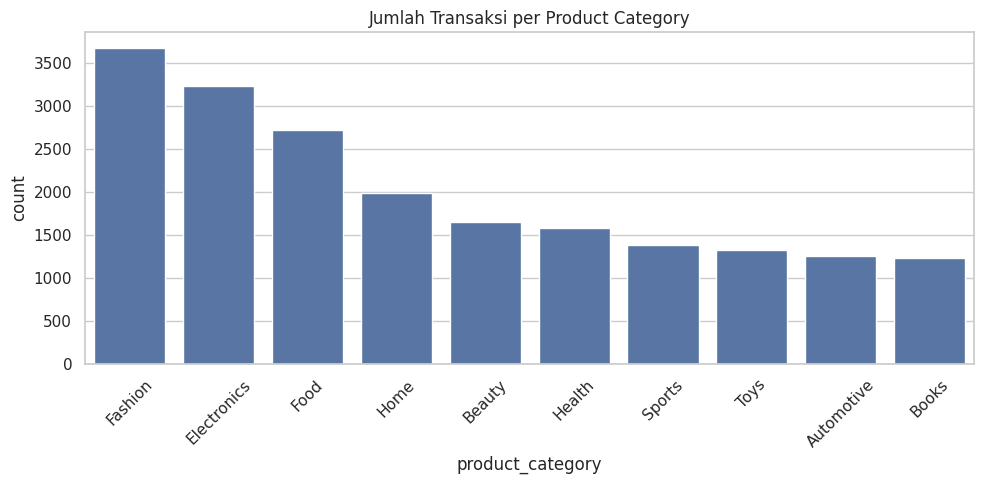

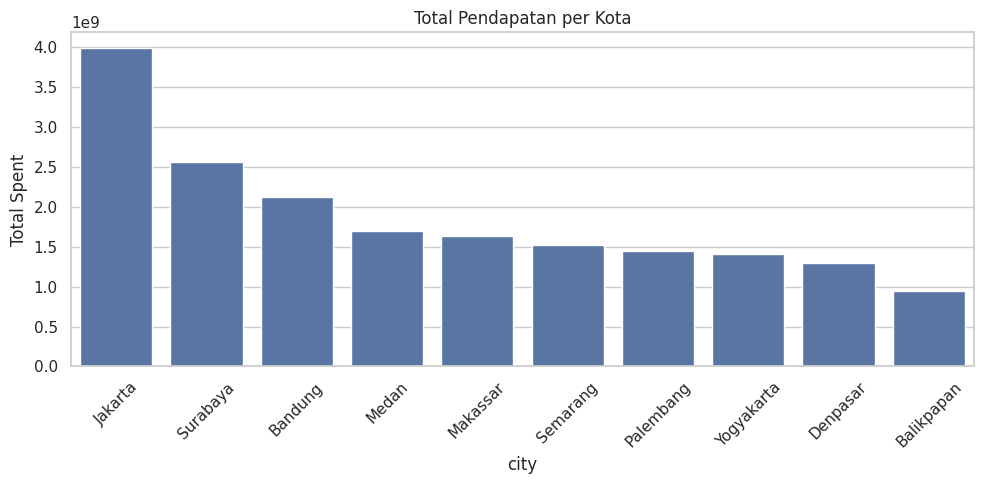

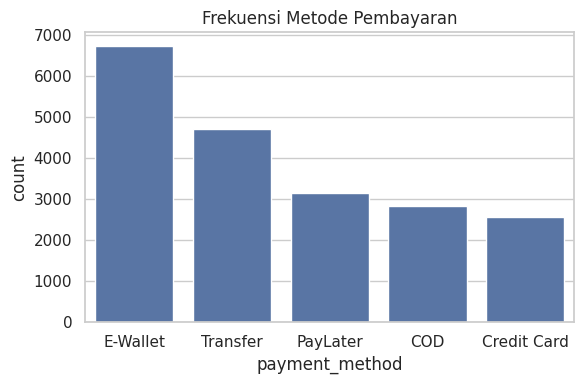

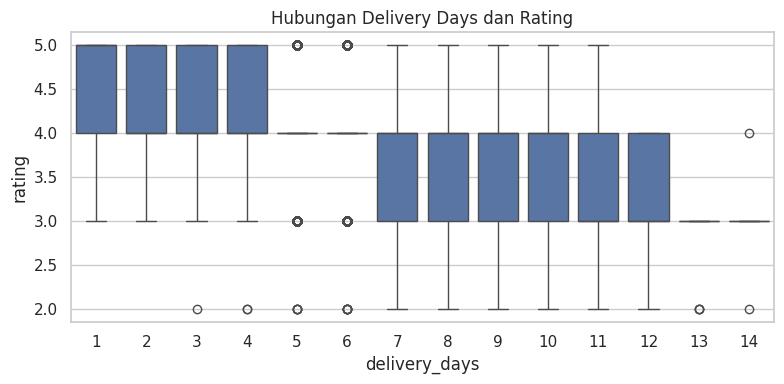

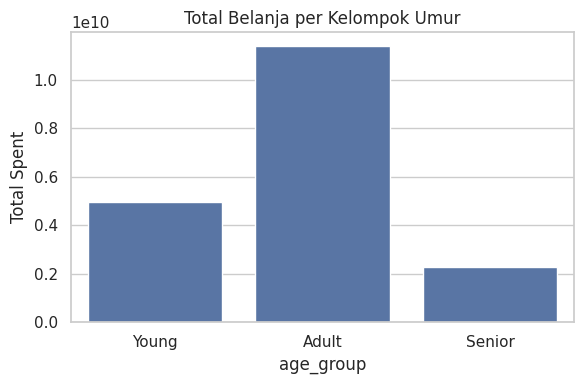

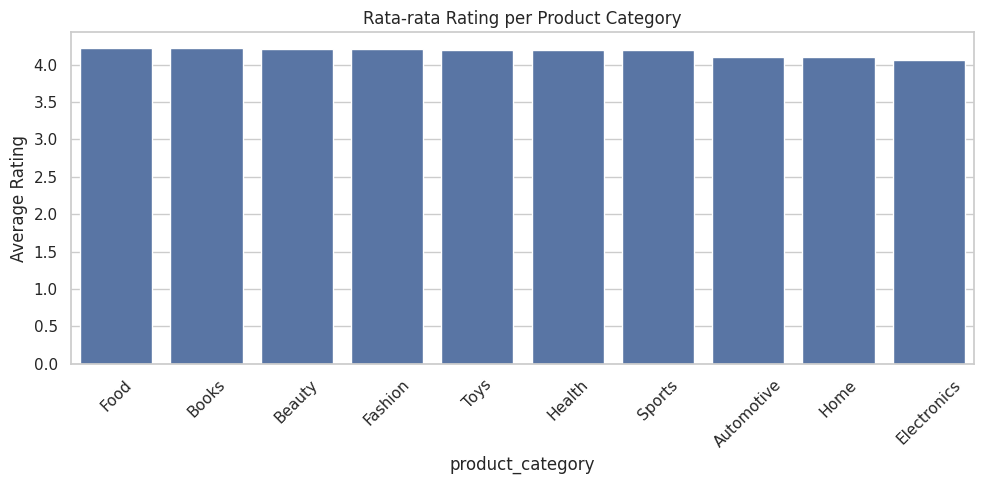

In [27]:
# ============================
# #BAGIAN_3_EDA_DENGAN_PANDAS_FIX
# ============================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

csv_path = "/content/TugasBESAR_synthetic_ecommerce_bigdata_20000.csv"
df_pd = pd.read_csv(csv_path)

# pastikan tipe datetime
df_pd['purchase_time'] = pd.to_datetime(df_pd['purchase_time'], errors='coerce')

# kalau age_group belum ada di CSV, buat lagi (aman dipanggil ulang)
if 'age_group' not in df_pd.columns:
    def make_age_group(a):
        if a < 25:
            return 'Young'
        elif a <= 40:
            return 'Adult'
        else:
            return 'Senior'
    df_pd['age_group'] = df_pd['age'].apply(make_age_group)

# 1) Distribusi transaksi per product_category
plt.figure(figsize=(10,5))
sns.countplot(
    data=df_pd,
    x='product_category',
    order=df_pd['product_category'].value_counts().index
)
plt.xticks(rotation=45)
plt.title('Jumlah Transaksi per Product Category')
plt.tight_layout()
plt.show()

# 2) Total pendapatan per kota
revenue_city = (
    df_pd
    .groupby('city', as_index=False)['total_spent']
    .sum()
    .sort_values('total_spent', ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(data=revenue_city, x='city', y='total_spent')
plt.xticks(rotation=45)
plt.title('Total Pendapatan per Kota')
plt.ylabel('Total Spent')
plt.tight_layout()
plt.show()

# 3) Metode pembayaran paling sering digunakan
plt.figure(figsize=(6,4))
sns.countplot(
    data=df_pd,
    x='payment_method',
    order=df_pd['payment_method'].value_counts().index
)
plt.title('Frekuensi Metode Pembayaran')
plt.tight_layout()
plt.show()

# 4) Hubungan delivery_days dan rating
plt.figure(figsize=(8,4))
sns.boxplot(data=df_pd, x='delivery_days', y='rating')
plt.title('Hubungan Delivery Days dan Rating')
plt.tight_layout()
plt.show()

# 5) Total belanja per age_group
age_revenue = (
    df_pd
    .groupby('age_group', as_index=False)['total_spent']
    .sum()
)

age_revenue['age_group'] = pd.Categorical(
    age_revenue['age_group'],
    categories=['Young', 'Adult', 'Senior'],
    ordered=True
)
age_revenue = age_revenue.sort_values('age_group')

plt.figure(figsize=(6,4))
sns.barplot(data=age_revenue, x='age_group', y='total_spent')
plt.title('Total Belanja per Kelompok Umur')
plt.ylabel('Total Spent')
plt.tight_layout()
plt.show()

# 6) Rata-rata rating per product_category
rating_prod = (
    df_pd
    .groupby('product_category', as_index=False)['rating']
    .mean()
    .sort_values('rating', ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(data=rating_prod, x='product_category', y='rating')
plt.xticks(rotation=45)
plt.title('Rata-rata Rating per Product Category')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()



In [28]:
# ============================================
# #BAGIAN_4_BIG_DATA_PROCESSING_PYSPARK
# ============================================

# Data sudah dalam df_spark (bersih & typed)

# Agregasi 1: pendapatan per kota
agg_city = df_spark.groupBy("city").agg(
    sum("total_spent").alias("total_revenue"),
    count("*").alias("total_transactions")
).orderBy(col("total_revenue").desc())
agg_city.show(10, truncate=False)

# Agregasi 2: rata-rata rating & delivery_days per kategori
agg_product = df_spark.groupBy("product_category").agg(
    avg("rating").alias("avg_rating"),
    avg("delivery_days").alias("avg_delivery_days")
).orderBy(col("avg_rating").desc())
agg_product.show(10, truncate=False)

# Agregasi 3: transaksi per payment_method & city
agg_payment = df_spark.groupBy("payment_method", "city").agg(
    count("*").alias("num_transactions"),
    sum("total_spent").alias("revenue")
).orderBy(col("num_transactions").desc())
agg_payment.show(10, truncate=False)

# Filtering skala besar: high value transactions (di atas Q75 total_spent)
q75 = df_spark.approxQuantile("total_spent", [0.75], 0.05)[0]
high_value_tx = df_spark.filter(col("total_spent") > q75)
print("Jumlah transaksi high value:", high_value_tx.count())
high_value_tx.select("user_id", "city", "total_spent").show(5, truncate=False)


+----------+-------------+------------------+
|city      |total_revenue|total_transactions|
+----------+-------------+------------------+
|Jakarta   |3.990488E9   |4280              |
|Surabaya  |2.559625E9   |2860              |
|Bandung   |2.131142E9   |2272              |
|Medan     |1.698797E9   |1823              |
|Makassar  |1.629958E9   |1730              |
|Semarang  |1.527682E9   |1618              |
|Palembang |1.448994E9   |1465              |
|Yogyakarta|1.40681E9    |1571              |
|Denpasar  |1.298882E9   |1340              |
|Balikpapan|9.4633E8     |1041              |
+----------+-------------+------------------+

+----------------+-----------------+------------------+
|product_category|avg_rating       |avg_delivery_days |
+----------------+-----------------+------------------+
|Food            |4.21997052321297 |3.474207811348563 |
|Books           |4.219233903830481|3.4343928280358598|
|Beauty          |4.214891041162228|3.4782082324455206|
|Fashion         |4

In [29]:
# ============================================
# #BAGIAN_5_ML_CLASSIFICATION_RATING
# (Low 1-2, Medium 3, High 4-5)
# ============================================

df_ml = df_spark_encoded.withColumn(
    "rating_class",
    when(col("rating") <= 2, "Low")
    .when(col("rating") == 3, "Medium")
    .otherwise("High")
)

label_indexer = StringIndexer(inputCol="rating_class", outputCol="label", handleInvalid="keep")

feature_cols = [
    "age", "price", "quantity", "delivery_days", "total_spent",
    "log_price", "log_total_spent"
] + [c + "_ohe" for c in ["gender", "city", "product_category", "payment_method", "age_group", "delivery_bucket"]]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
pipeline_lr = Pipeline(stages=[label_indexer, assembler, lr])
model_lr = pipeline_lr.fit(train_df)
pred_lr = model_lr.transform(test_df)

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50, maxDepth=8, seed=42)
pipeline_rf = Pipeline(stages=[label_indexer, assembler, rf])
model_rf = pipeline_rf.fit(train_df)
pred_rf = model_rf.transform(test_df)

evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

acc_lr = evaluator_acc.evaluate(pred_lr)
acc_rf = evaluator_acc.evaluate(pred_rf)

print("Accuracy Logistic Regression :", acc_lr)
print("Accuracy Random Forest       :", acc_rf)

# Confusion matrix untuk model terbaik (Random Forest)
pred_best = pred_rf
confusion = pred_best.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion.show()

label_mapping = model_rf.stages[0].labels
print("Label index mapping:", label_mapping)


Accuracy Logistic Regression : 0.8850050658561297
Accuracy Random Forest       : 0.8847517730496454
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 3475|
|  0.0|       1.0|    5|
|  1.0|       0.0|  443|
|  1.0|       1.0|   18|
|  2.0|       0.0|    7|
+-----+----------+-----+

Label index mapping: ['High', 'Medium', 'Low']


In [30]:
# ============================================
# #BAGIAN_6_BANTUAN_INSIGHT_BISNIS
# ============================================

print("TOP 10 kota berdasarkan revenue:")
agg_city.show(10, truncate=False)

print("TOP 10 kategori berdasarkan rata-rata rating:")
agg_product.show(10, truncate=False)

print("Metode pembayaran paling sering:")
df_spark.groupBy("payment_method").agg(count("*").alias("n")).orderBy(col("n").desc()).show()

print("Rata-rata total_spent per age_group:")
df_spark.groupBy("age_group").agg(avg("total_spent").alias("avg_total_spent")).orderBy(col("avg_total_spent").desc()).show()

print("Rata-rata rating per delivery_bucket:")
df_spark.groupBy("delivery_bucket").agg(avg("rating").alias("avg_rating")).orderBy(col("avg_rating").desc()).show()


TOP 10 kota berdasarkan revenue:
+----------+-------------+------------------+
|city      |total_revenue|total_transactions|
+----------+-------------+------------------+
|Jakarta   |3.990488E9   |4280              |
|Surabaya  |2.559625E9   |2860              |
|Bandung   |2.131142E9   |2272              |
|Medan     |1.698797E9   |1823              |
|Makassar  |1.629958E9   |1730              |
|Semarang  |1.527682E9   |1618              |
|Palembang |1.448994E9   |1465              |
|Yogyakarta|1.40681E9    |1571              |
|Denpasar  |1.298882E9   |1340              |
|Balikpapan|9.4633E8     |1041              |
+----------+-------------+------------------+

TOP 10 kategori berdasarkan rata-rata rating:
+----------------+-----------------+------------------+
|product_category|avg_rating       |avg_delivery_days |
+----------------+-----------------+------------------+
|Food            |4.21997052321297 |3.474207811348563 |
|Books           |4.219233903830481|3.43439282803585